# Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection 
This is the code for the paper entitled "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)" accepted in Workshop on Autonomous Cybersecurity (AutonomousCyber 2024), ACM CCS 2024 (Top Cybersecurity Conference).  
Authors: Li Yang (liyanghart@gmail.com) and Abdallah Shami  

If you find this repository useful in your research, please cite:  
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [3]:
# Read the dataset
df = pd.read_csv('../../dataset/ExtractFlowsOutput/wedfri_train_optimized.csv', parse_dates=['Timestamp'])

In [4]:
df_test = pd.read_csv('../../dataset/ExtractFlowsOutput/wedfri_test_optimized.csv', parse_dates=['Timestamp'])

In [5]:
df_test['Label'].value_counts()

Label
Benign       120990
Portscan      31786
Slowloris      1139
Name: count, dtype: int64

In [6]:
df_benign = df[df['Label'] == 'Benign'].sort_values(by='Timestamp')
df_ps = df[df['Label'] == 'Portscan'].sort_values(by='Timestamp')
df_dos = df[df['Label'] == 'Slowloris'].sort_values(by='Timestamp')

In [7]:
df_benign_val = df_benign.iloc[-120990:]
df_benign_train = df_benign[~df_benign.index.isin(df_benign_val.index)]
df_ps_val = df_ps.iloc[-31786:]
df_ps_train = df_ps[~df_ps.index.isin(df_ps_val.index)]
df_dos_val = df_dos.iloc[-1139:]
df_dos_train = df_dos[~df_dos.index.isin(df_dos_val.index)]

In [31]:
# df['Label'] = df['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df = df.dropna(subset=['Label'])
# df['Label'].value_counts(dropna=False)

In [30]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').reset_index().iloc[700]['Timestamp']

In [29]:
# df_test['Label'] = df_test['Label'].map({
#     "Benign": "Benign",
#     "Slowloris": "Slowloris"
# })
# df_test = df_test.dropna(subset=['Label'])
# df_test['Label'].value_counts(dropna=False)

In [24]:
# df_test[df_test['Label'] == 'Slowloris'].sort_values(by='Timestamp').iloc[:int(len(df_test[df_test['Label'] == 'Slowloris'])*(1/2))]

In [25]:
# randomizing = df_test[df_test['Timestamp'] <= pd.Timestamp('2017-07-05 13:08:15.865809')]
# df_test = df_test[~df_test.index.isin(randomizing.index)]

In [26]:
# df = pd.concat([df, randomizing])

In [27]:
# # print the class distribution of the last column
# df['Label'].value_counts()

In [28]:
# df_test['Label'].value_counts()

In [8]:
df_train = pd.concat([df_benign_train, df_ps_train, df_dos_train])
df_val = pd.concat([df_benign_val, df_ps_val, df_dos_val])

In [9]:
df_train['Label'].value_counts()

Label
Benign       363427
Portscan      95468
Slowloris      3424
Name: count, dtype: int64

In [10]:
df_val['Label'].value_counts()

Label
Benign       120990
Portscan      31786
Slowloris      1139
Name: count, dtype: int64

In [11]:
df_train = df_train.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
df_val = df_val.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)
df_test = df_test.drop(['index', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1)

In [12]:
X_test = df_test.drop('Label', axis=1)

In [13]:
y_test = df_test['Label']

### Data pre-processing

In [14]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [15]:
df['Label'].value_counts()

Label
0    484417
1    127254
2      4563
Name: count, dtype: int64

In [16]:
y_test = labelencoder.transform(y_test)
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
df.isnull().any().any()

False

In [18]:
df.isna().any().any()

False

In [25]:
# address empty values
# if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
#     print("THERE ARE")
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)
#     df.fillna(0, inplace = True) 

In [43]:
# # Debug
# X_train = df.drop(['Label'],axis=1).values 
# y_train = df['Label'].values.reshape(-1,1)
# X_val = X_test
# y_val = y_test

In [44]:
# # Split the dataset into training and testing
# X = df.drop(['Label'],axis=1).values 
# y = df['Label'].values.reshape(-1,1)
# y=np.ravel(y)
# X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0,stratify = y)
# # 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [26]:
X_train = df_train.drop(["Label"], axis=1)
y_train = labelencoder.transform(df_train["Label"])
X_val = df_val.drop(["Label"], axis=1)
y_val = labelencoder.transform(df_val["Label"])

In [23]:
labelencoder.classes_

array(['Benign', 'Portscan', 'Slowloris'], dtype=object)

## Machine learning model training

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

In [26]:
pd.set_option('display.max_columns', None)

In [23]:
len(X_train)

393700

In [24]:
len(y_train)

393700

In [25]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train, y_train, cv=3, n_jobs=4)

# calculate the training time
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time:  12.516357183456421
Prediction time per sample:  0.00021909136205676378
Cross-Validation scores:  [0.99709942 0.99960417 0.99991564]
Mean of Cross-Validation scores:  0.9988730763253476


ValueError: Mix of label input types (string and number)

In [33]:
df_test.reset_index()[(pd.Series(y_test) != pd.Series(y_predict))]

,index,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd RST Flags,Bwd RST Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Bwd Act Data Pkts,Fwd Seg Size Min,Bwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label
168,2783,6,72778493.0,14,3,2318.0,0.0,231.0,0.0,165.571429,107.374051,0.0,0.0,0.0,0.0,3.185007e+01,0.233585,4.548656e+06,7.191506e+06,21444386.0,22.0,72778425.0,5.598340e+06,7.634231e+06,21444386.0,313.0,72778471.0,36389235.5,6.896481e+06,41265784.0,31512687.0,11,0,0,0,0,1,456,100,0.192365,0.041221,0.0,231.0,136.352941,116.621150,13600.492647,1,3,1,11,15,0,0,0,0.214286,136.352941,165.571429,0.0,1155.0,5.0,723.036830,0.0,0.0,0.0,2.000000,331.142857,0.428571,0.0,29200,28960,11,0,32,0,3203493.0,4.529742e+06,6406504.0,482.0,13274287.8,7.281136e+06,21444386.0,5842418.0,0,0,9,1,10,0,Slowloris
173,2788,6,74428069.0,14,3,2318.0,0.0,231.0,0.0,165.571429,107.374051,0.0,0.0,0.0,0.0,3.114416e+01,0.228408,4.651754e+06,7.474147e+06,23108915.0,47.0,74427993.0,5.725230e+06,7.948021e+06,23108915.0,325.0,74428022.0,37214011.0,8.264828e+06,43058127.0,31369895.0,11,0,0,0,0,1,456,100,0.188101,0.040307,0.0,231.0,136.352941,116.621150,13600.492647,1,3,1,11,15,0,0,0,0.214286,136.352941,165.571429,0.0,1155.0,5.0,722.464260,0.0,0.0,0.0,2.000000,331.142857,0.428571,0.0,29200,28960,11,0,32,0,3204022.0,4.530483e+06,6407557.0,487.0,13603989.8,7.827913e+06,23108915.0,5714414.0,0,0,9,1,10,0,Slowloris
190,2805,6,72780666.0,14,3,2318.0,0.0,231.0,0.0,165.571429,107.374051,0.0,0.0,0.0,0.0,3.184912e+01,0.233579,4.548792e+06,7.191609e+06,21445469.0,49.0,72780617.0,5.598509e+06,7.634328e+06,21445469.0,245.0,72780607.0,36390303.5,6.896391e+06,41266788.0,31513819.0,11,0,0,0,0,1,456,100,0.192359,0.041220,0.0,231.0,136.352941,116.621150,13600.492647,1,3,1,11,15,0,0,0,0.214286,136.352941,165.571429,0.0,1155.0,5.0,722.506290,0.0,0.0,0.0,2.000000,331.142857,0.428571,0.0,29200,28960,11,0,32,0,3204068.5,4.530551e+06,6407652.0,485.0,13274496.0,7.281377e+06,21445469.0,5842647.0,0,0,9,1,10,0,Slowloris
191,2806,6,71568001.0,14,3,2318.0,0.0,231.0,0.0,165.571429,107.374051,0.0,0.0,0.0,0.0,3.238878e+01,0.237536,4.473000e+06,6.996655e+06,20229560.0,12.0,71567989.0,5.505230e+06,7.418615e+06,20229560.0,275.0,71567928.0,35783964.0,5.943727e+06,39986814.0,31581114.0,11,0,0,0,0,1,456,100,0.195618,0.041918,0.0,231.0,136.352941,116.621150,13600.492647,1,3,1,11,15,0,0,0,0.214286,136.352941,165.571429,0.0,1155.0,5.0,722.811945,0.0,0.0,0.0,2.000000,331.142857,0.428571,0.0,29200,28960,11,0,32,0,3205773.0,4.532826e+06,6410965.0,581.0,13031288.6,6.921089e+06,20229560.0,5906614.0,0,0,9,1,10,0,Slowloris
193,2808,6,71569241.0,14,3,2318.0,0.0,231.0,0.0,165.571429,107.374051,0.0,0.0,0.0,0.0,3.238822e+01,0.237532,4.473078e+06,6.996618e+06,20229602.0,42.0,71569199.0,5.505323e+06,7.

In [29]:
pd.Series(y_test).value_counts()

0    120990
1     31786
2      1139
Name: count, dtype: int64

Prediction time per sample:  0.00018763091223915153
Accuracy of DT: 0.999885368050438
Precision of DT: 0.9998854819563128
Recall of DT: 0.999885368050438
F1-score of DT: 0.9998854178098161
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60495
           1       0.99      0.99      0.99       570

    accuracy                           1.00     61065
   macro avg       1.00      1.00      1.00     61065
weighted avg       1.00      1.00      1.00     61065



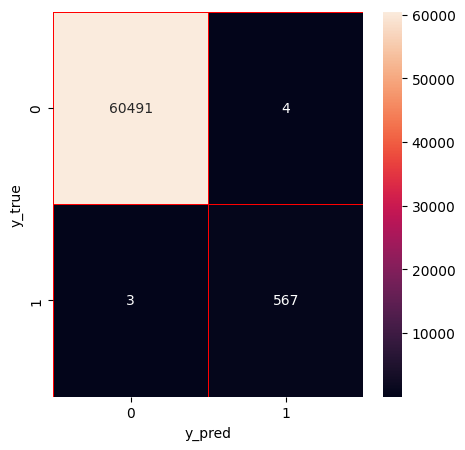

In [32]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00022679689939151572
Cross-Validation scores:  [0.99938182 0.99944192 0.99955353]
Mean of Cross-Validation scores:  0.999459089946423
Accuracy of DT: 0.9927629921920913
Precision of DT: 0.9928297889882978
Recall of DT: 0.9927629921920913
F1-score of DT: 0.9927475485298931
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     21298
           1       0.99      1.00      0.99     38257

    accuracy                           0.99     59555
   macro avg       0.99      0.99      0.99     59555
weighted avg       0.99      0.99      0.99     59555



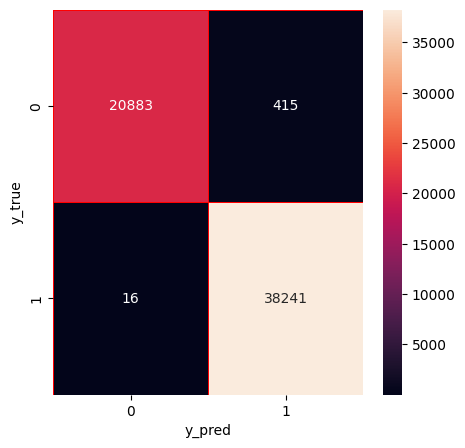

In [ ]:
# # calculate the prediction time per sample in milliseconds
# start = time.time()
# y_predict = dt.predict(X_val)
# end = time.time()
# print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

# y_true = y_val

# # Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# # Evaluation metrics
# dt_score = dt.score(X_val, y_val)
# precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# # Print results
# print('Accuracy of DT: ' + str(dt_score))
# print('Precision of DT: ' + str(precision))
# print('Recall of DT: ' + str(recall))
# print('F1-score of DT: ' + str(fscore))
# print(classification_report(y_true, y_predict))

# # Confusion matrix visualization
# cm = confusion_matrix(y_true, y_predict)
# f, ax = plt.subplots(figsize=(5, 5))
# sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
# plt.xlabel("y_pred")
# plt.ylabel("y_true")
# plt.show()

In [ ]:
pd.read_csv("/mnt/extra/datasets/processing-fixed/friday_binary_ps")

#### RF

Training time:  16.884214878082275
Prediction time:  0.0012691345075190158 ms
Cross-Validation scores:  [0.99994807 0.99997404 0.99997404]
Mean of Cross-Validation scores:  0.9999653811160476
Accuracy of RF: 0.9999740359213029
Precision of RF: 0.9999740364469176
Recall of RF: 0.9999740359213029
F1-score of RF: 0.9999740232626625
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121105
           1       1.00      1.00      1.00     31813
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154059
   macro avg       1.00      1.00      1.00    154059
weighted avg       1.00      1.00      1.00    154059



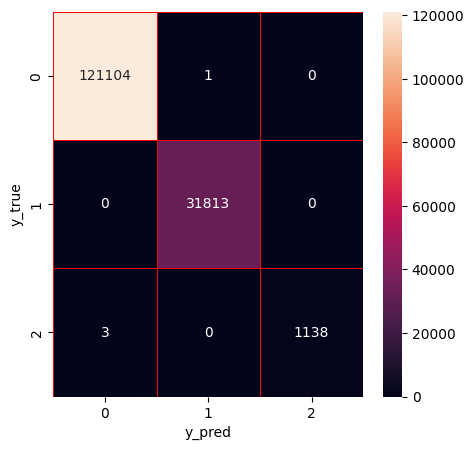

In [19]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.001113515373745249 ms
Accuracy of RF: 0.9971412792775233
Precision of RF: 0.9971510551812582
Recall of RF: 0.9971412792775233
F1-score of RF: 0.9969240155950297
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120990
           1       1.00      1.00      1.00     31786
           2       1.00      0.68      0.81      1139

    accuracy                           1.00    153915
   macro avg       1.00      0.89      0.94    153915
weighted avg       1.00      1.00      1.00    153915



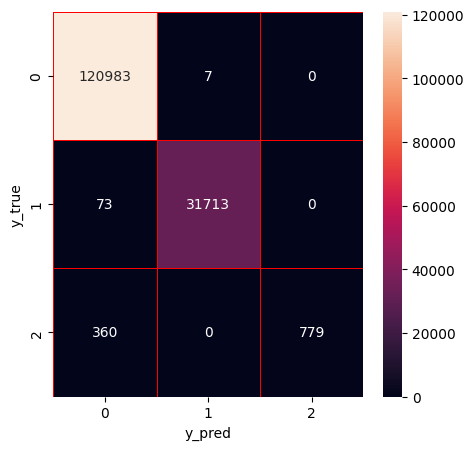

In [31]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', rf_scores)
# print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0019959942925037253
Cross-Validation scores:  [0.99998476 0.99999238 0.99999238]
Mean of Cross-Validation scores:  0.999989839992583
Accuracy of RF: 0.9997802560017579
Precision of RF: 0.9997803240532684
Recall of RF: 0.9997802560017579
F1-score of RF: 0.9997802314672894
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38737
           1       1.00      1.00      1.00     15872

    accuracy                           1.00     54609
   macro avg       1.00      1.00      1.00     54609
weighted avg       1.00      1.00      1.00     54609



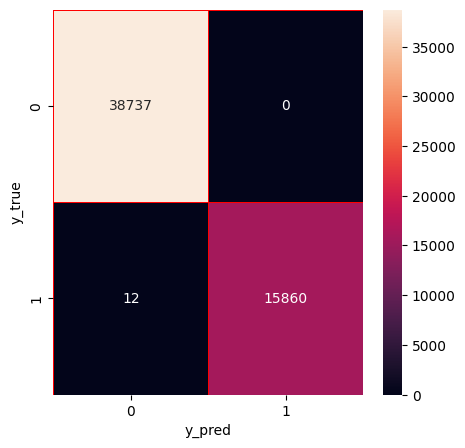

In [ ]:
# # calculate the prediction time per sample in milliseconds
# start = time.time()
# y_predict = rf.predict(X_val)
# end = time.time()
# print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

# y_true = y_val

# # Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', rf_scores)
# print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# # Evaluation metrics
# rf_score = rf.score(X_val, y_val)
# precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# # Print results
# print('Accuracy of RF: ' + str(rf_score))
# print('Precision of RF: ' + str(precision))
# print('Recall of RF: ' + str(recall))
# print('F1-score of RF: ' + str(fscore))
# print(classification_report(y_true, y_predict))

# # Confusion matrix visualization
# cm = confusion_matrix(y_true, y_predict)
# f, ax = plt.subplots(figsize=(5, 5))
# sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
# plt.xlabel("y_pred")
# plt.ylabel("y_true")
# plt.show()

#### ET

Training time:  15.050697803497314
Prediction time:  0.0012614755356447752 ms
Cross-Validation scores:  [0.99996105 0.99998702 0.99998702]
Mean of Cross-Validation scores:  0.9999783632115743
Accuracy of ET: 0.9999675449016286
Precision of ET: 0.9999675457488223
Recall of ET: 0.9999675449016286
F1-score of ET: 0.9999675223581245
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121105
           1       1.00      1.00      1.00     31813
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154059
   macro avg       1.00      1.00      1.00    154059
weighted avg       1.00      1.00      1.00    154059



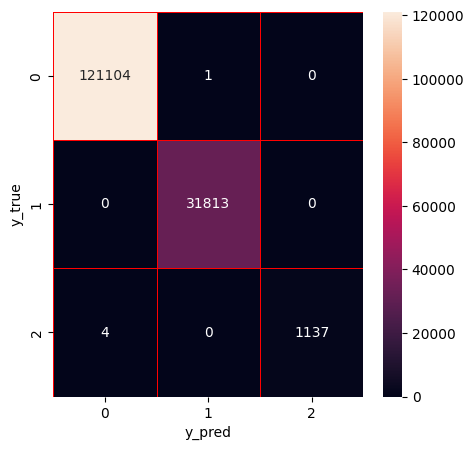

In [20]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  3.8571200370788574
Prediction time per sample:  0.0003824533682119781
Cross-Validation scores:  [0.99996105 0.99997404 0.99998053]
Mean of Cross-Validation scores:  0.9999718721497665
Accuracy of XGBoost: 0.9999675449016286
Precision of XGBoost: 0.9999675449984615
Recall of XGBoost: 0.9999675449016286
F1-score of XGBoost: 0.999967544885639
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121105
           1       1.00      1.00      1.00     31813
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154059
   macro avg       1.00      1.00      1.00    154059
weighted avg       1.00      1.00      1.00    154059



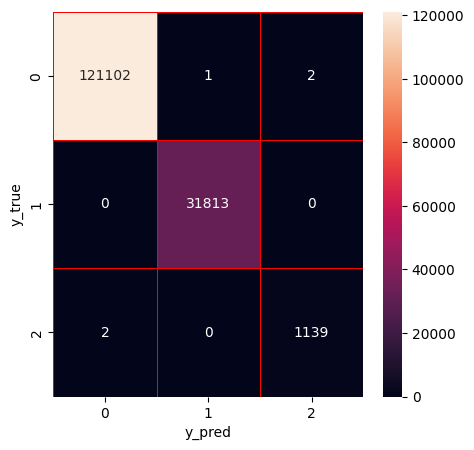

In [21]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [42]:
pd.Series(y_predict)[pd.Series(y_predict) != pd.Series(y_true)]

2839    0
2840    0
2841    0
2842    0
2843    0
       ..
3484    0
3872    0
3873    0
3874    0
3875    0
Length: 286, dtype: int64

In [51]:
X_test

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time
0,6,85742.0,10,6,527.0,5098.0,192.0,0.0,52.700000,77.209743,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,6,1038445.0,10,12,703.0,3950.0,267.0,0.0,70.300000,100.477803,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,6,70672.0,5,5,429.0,858.0,429.0,0.0,85.800000,191.854632,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
3,6,217279.0,9,11,2246.0,6435.0,1701.0,0.0,249.555556,558.017946,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
4,6,219470.0,8,8,545.0,4505.0,342.0,0.0,68.125000,131.499525,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153910,6,72263.0,8,4,1612.0,1264.0,403.0,0.0,201.500000,215.412561,...,0.0,0.0,0.0,0.0,0,0,4,2,6,0
153911,17,261.0,2,2,64.0,96.0,32.0,32.0,32.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
153912,6,247267.0,16,12,1624.0,1908.0,252.0,0.0,101.500000,90.077004,...,0.0,0.0,0.0,0.0,0,0,8,6,14,0
153913,17,125.0,2,2,96.0,96.0,48.0,48.0,48.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [50]:
df_test.iloc[[3484]]

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label
3484,6,5025323.0,8,8,395.0,9375.0,395.0,0.0,49.375,139.653589,...,0.0,5002022.0,5002022.0,0,0,0,0,0,0,Slowloris


#### LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16626
[LightGBM] [Info] Number of data points in the train set: 308117, number of used features: 81
[LightGBM] [Info] Start training from score -0.240683
[LightGBM] [Info] Start training from score -1.577426
[LightGBM] [Info] Start training from score -4.905866
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16619
[LightGBM] [Info] Number of data points in the train set: 308117, number of used features: 81
[LightGBM] [Info] Start training from score -0.240683
[LightGBM] [Info] Start training from score -1.577442
[LightGBM] [Info] St

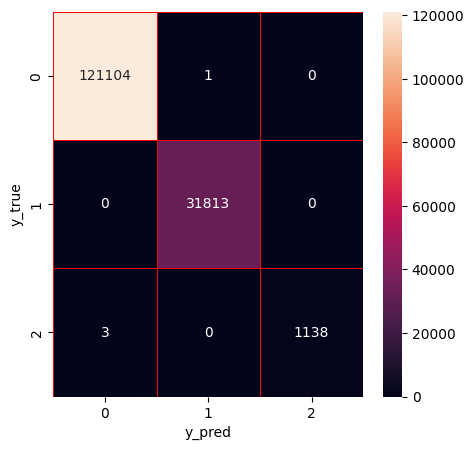

In [22]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train, y_train, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0013486763478580152
Cross-Validation scores:  [0.99994158 0.99998053 0.99998053]
Mean of Cross-Validation scores:  0.9999675448173614
Accuracy of LightGBM: 0.9975376019231394
Precision of LightGBM: 0.9975452169177812
Recall of LightGBM: 0.9975376019231394
F1-score of LightGBM: 0.9973806498966069
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120990
           1       1.00      1.00      1.00     31786
           2       1.00      0.73      0.84      1139

    accuracy                           1.00    153915
   macro avg       1.00      0.91      0.95    153915
weighted avg       1.00      1.00      1.00    153915



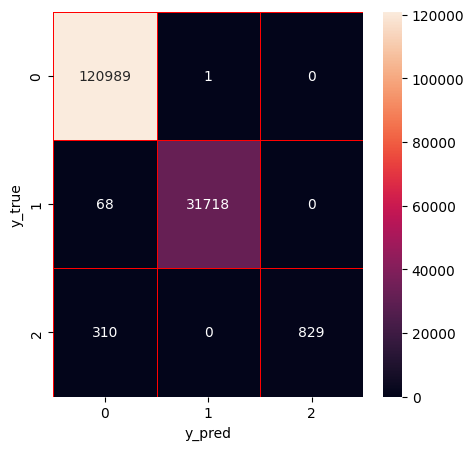

In [25]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)



y_true = y_test

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Catboost

Training time:  65.97502064704895
Prediction time per sample:  0.009783442842072743
Cross-Validation scores:  [0.99996105 0.99995456 0.99997404]
Mean of Cross-Validation scores:  0.9999632174006892
Accuracy of CatBoost: 0.9999675449016286
Precision of CatBoost: 0.9999675338687004
Recall of CatBoost: 0.9999675449016286
F1-score of CatBoost: 0.9999675336318807
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121105
           1       1.00      1.00      1.00     31813
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154059
   macro avg       1.00      1.00      1.00    154059
weighted avg       1.00      1.00      1.00    154059



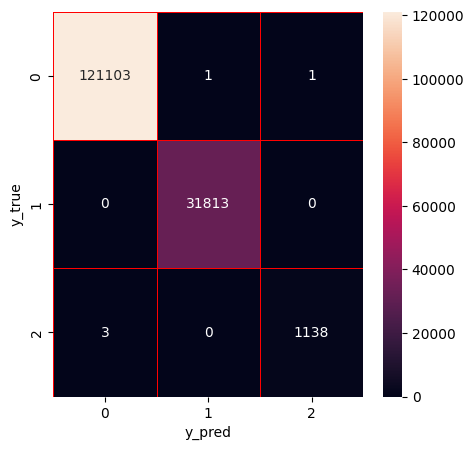

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)
cat_scores = cross_val_score(cat, X_train, y_train, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train, y_train)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [24]:
# record the results
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train)
cat_prob_test=cat.predict_proba(X_val)


In [41]:
import joblib

joblib.dump(dt, "./fixed_friday_training_models/pre_fs/dt.pkl")
joblib.dump(rf, "./fixed_friday_training_models/pre_fs/rf.pkl")
joblib.dump(et, "./fixed_friday_training_models/pre_fs/et.pkl")
joblib.dump(xg, "./fixed_friday_training_models/pre_fs/xg.pkl")
joblib.dump(lgbm, "./fixed_friday_training_models/pre_fs/lgbm.pkl")
joblib.dump(cat, "./fixed_friday_training_models/pre_fs/cat.pkl")

['./fixed_friday_training_models/pre_fs/cat.pkl']

In [25]:
import gc
gc.collect()

176

## Model selection

In [26]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [27]:
top_3_models

['et', 'xg', 'lgbm']

## Model Ensemble

In [28]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

Training time of Stacking: 0.21280980110168457
Testing time of Stacking: 4.458062252529254e-05
Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



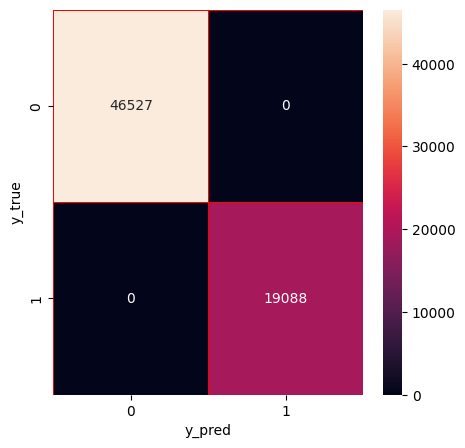

In [47]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0, n_jobs=8).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 0.2591123580932617
Testing time of Stacking: 3.51005635010454e-05
Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



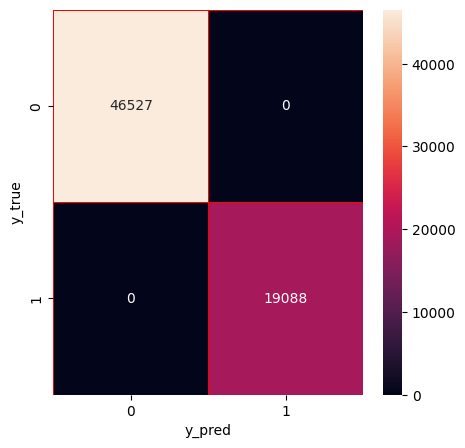

In [48]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 0.22820186614990234
Testing time of Stacking: 0.00011045776706710964
Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



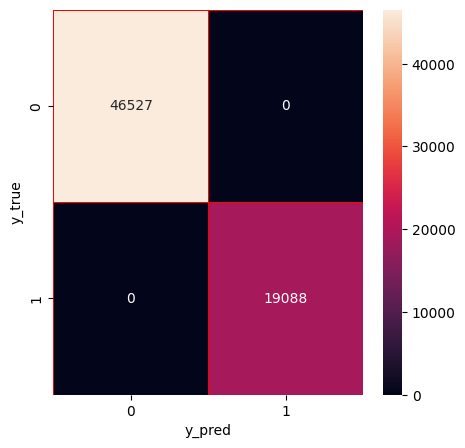

In [49]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [54]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [55]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [56]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.2869, 'Flow Duration'), (0.1227, 'Bwd RST Flags'), (0.0449, 'RST Flag Count'), (0.0365, 'SYN Flag Count'), (0.0355, 'Fwd Seg Size Min'), (0.0306, 'Protocol'), (0.0279, 'Total Fwd Packet'), (0.0269, 'FWD Init Win Bytes'), (0.02, 'Fwd Packets/s'), (0.0194, 'Down/Up Ratio'), (0.0182, 'Flow Packets/s'), (0.0174, 'Bwd Packets/s'), (0.0158, 'Bwd Init Win Bytes'), (0.0152, 'Total Length of Bwd Packet'), (0.015, 'Flow IAT Min'), (0.0134, 'Flow IAT Mean'), (0.0123, 'Total Length of Fwd Packet'), (0.0115, 'Fwd IAT Min'), (0.0108, 'Bwd Packet Length Std'), (0.0107, 'Fwd Packet Length Max'), (0.0105, 'Packet Length Mean'), (0.0102, 'Fwd Header Length'), (0.0095, 'Fwd Packet Length Std'), (0.0092, 'FIN Flag Count'), (0.0084, 'Bwd Packet Length Mean'), (0.0081, 'Active Min'), (0.0072, 'Fwd Packet Length Mean'), (0.0066, 'Flow IAT Max'), (0.0061, 'Fwd Packet Length Min'), (0.0058, 'Bwd IAT Mean'), (0.0057, 'Packet Length Std'), (0.0054, 'Bwd IAT Max'), (0.0052, 'Fw

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9: # TODO: change back maybe
        break        

In [60]:
# regenerate the training and test sets with the selected features

X_fs = df[fs].values
X_train, X_val, y_train, y_val = train_test_split(X_fs,y, train_size = 1-0.136362837, test_size = 0.136362837, random_state = 0,stratify = y)

In [64]:
X_train.shape

(532202, 21)

In [63]:
# save the dataset with the selected features
df_fs = pd.DataFrame(X_fs, columns=fs)
df_fs['Label'] = y
# df_fs.to_csv('fixed_friday_training_models/ps_train_fs.csv', index=False)

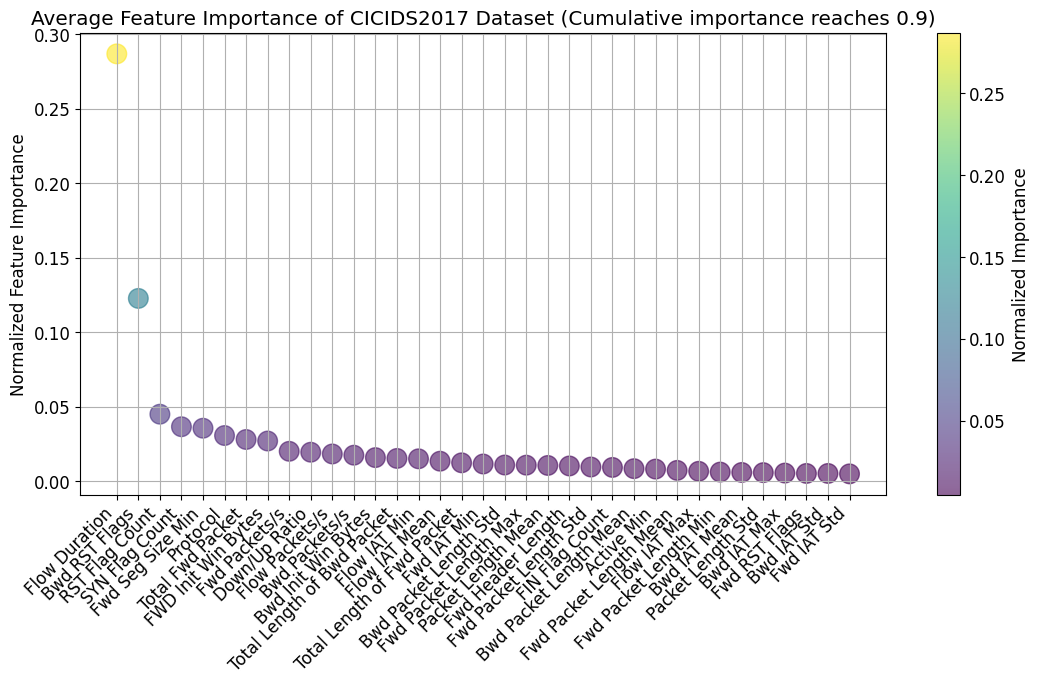

In [61]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': df.drop(['Label'],axis=1).columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [62]:
print(fs)

['Flow Duration', 'Bwd RST Flags', 'RST Flag Count', 'SYN Flag Count', 'Fwd Seg Size Min', 'Protocol', 'Total Fwd Packet', 'FWD Init Win Bytes', 'Fwd Packets/s', 'Down/Up Ratio', 'Flow Packets/s', 'Bwd Packets/s', 'Bwd Init Win Bytes', 'Total Length of Bwd Packet', 'Flow IAT Min', 'Flow IAT Mean', 'Total Length of Fwd Packet', 'Fwd IAT Min', 'Bwd Packet Length Std', 'Fwd Packet Length Max', 'Packet Length Mean']


### Data Balancing by Proposed TVAE-based Method

In [59]:
pd.Series(y_train).value_counts()

0    294673
1    120891
Name: count, dtype: int64

In [60]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_csv(filepath='fixed_friday_training_models/ps_train_fs.csv')


In [61]:
training_set, test_set = train_test_split(df, test_size = 0.136362837, random_state = 0,stratify = df['Label'])
X_train = training_set[fs]
y_train = training_set.iloc[:, -1]
X_val = test_set[fs]
y_val = test_set.iloc[:, -1]

In [62]:
training_set['Label'].value_counts()

Label
0    294673
1    120891
Name: count, dtype: int64

In [63]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [64]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)


In [65]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    294673
1    120891
Name: count, dtype: int64


In [77]:
X_val.reset_index(drop=True).to_csv("fixed_friday_training_models/fs_X_val.csv", index=False)

In [79]:
X_train_balanced.to_csv("fixed_friday_training_models/fs_X_train_balanced.csv", index=False)

In [80]:
y_val.reset_index(drop=True).to_csv("fixed_friday_training_models/fs_y_val.csv", index=False)

In [83]:
y_train_balanced.to_csv("fixed_friday_training_models/fs_y_val.csv", index=False)

# Testing

In [66]:
X_train_balanced = df_fs.drop(['Label'], axis=1)
y_train_balanced = df_fs['Label']

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

### DT

Training time:  5.0122692584991455
Prediction time per sample:  4.4731855937205284e-05
Cross-Validation scores:  [0.99786283 0.99995619 0.99995619]
Mean of Cross-Validation scores:  0.9992584008600128
Accuracy of DT: 0.9999880997715156
Precision of DT: 0.9999881004572497
Recall of DT: 0.9999880997715156
F1-score of DT: 0.9999880998979159
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66057
           1       1.00      1.00      1.00     17353
           2       1.00      1.00      1.00       622

    accuracy                           1.00     84032
   macro avg       1.00      1.00      1.00     84032
weighted avg       1.00      1.00      1.00     84032



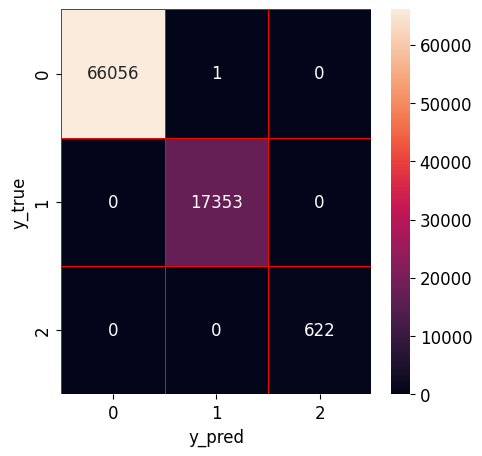

In [77]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [44]:
X_test

,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time
0,6,85742.0,10,6,527.0,5098.0,192.0,0.0,52.700000,77.209743,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
1,6,1038445.0,10,12,703.0,3950.0,267.0,0.0,70.300000,100.477803,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
2,6,70672.0,5,5,429.0,858.0,429.0,0.0,85.800000,191.854632,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
3,6,217279.0,9,11,2246.0,6435.0,1701.0,0.0,249.555556,558.017946,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
4,6,219470.0,8,8,545.0,4505.0,342.0,0.0,68.125000,131.499525,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153910,6,72263.0,8,4,1612.0,1264.0,403.0,0.0,201.500000,215.412561,...,0.0,0.0,0.0,0.0,0,0,4,2,6,0
153911,17,261.0,2,2,64.0,96.0,32.0,32.0,32.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
153912,6,247267.0,16,12,1624.0,1908.0,252.0,0.0,101.500000,90.077004,...,0.0,0.0,0.0,0.0,0,0,8,6,14,0
153913,17,125.0,2,2,96.0,96.0,48.0,48.0,48.000000,0.000000,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [68]:
X_test = df_test[fs]
y_test = labelencoder.transform(df_test['Label'])

Prediction time per sample:  6.168537606459684e-05
Accuracy of DT: 0.9948997823473995
Precision of DT: 0.9949641510754476
Recall of DT: 0.9948997823473995
F1-score of DT: 0.994905198736058
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    120990
           1       0.98      1.00      0.99     31786
           2       1.00      0.93      0.96      1139

    accuracy                           0.99    153915
   macro avg       0.99      0.97      0.98    153915
weighted avg       0.99      0.99      0.99    153915



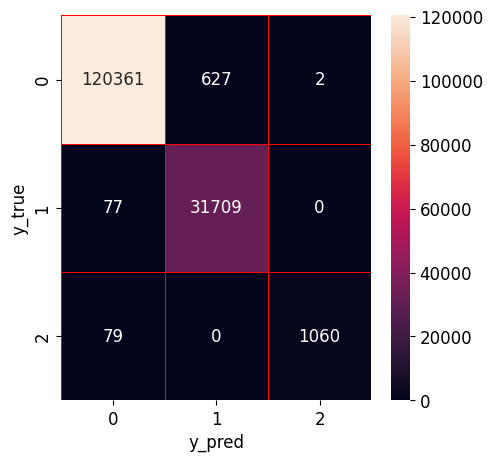

In [78]:
start = time.time()
y_predict = dt.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test)*1000)

y_true = y_test

# Print out the cross-validation scores and mean of them
# print('Cross-Validation scores: ', dt_scores)
# print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [87]:
joblib.dump(dt, "fixed_friday_training_models/post_fs/dt_untuned.pkl")

['fixed_friday_training_models/post_fs/dt_untuned.pkl']

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:34<00:00,  1.74s/trial, best loss: -0.9999639045115506]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 4}
Accuracy of DT: 0.9999847595824125
Precision of DT: 0.9999847603808001
Recall of DT: 0.9999847595824125
F1-score of DT: 0.9999847597001235
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



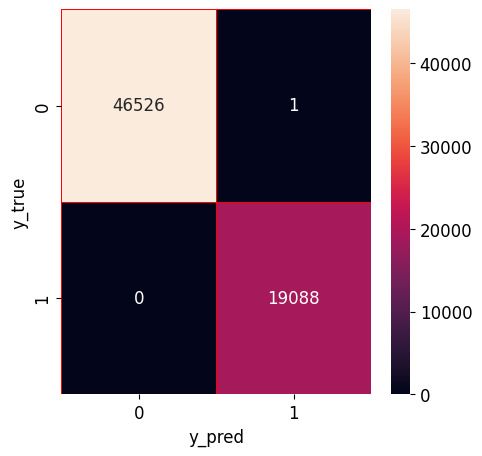

In [88]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, n_jobs=8, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [89]:
joblib.dump(dt, "fixed_friday_training_models/post_fs/dt.pkl")

['fixed_friday_training_models/post_fs/dt.pkl']

### RF

Training time:  12.254028081893921
Prediction time:  0.0006876749703653514 ms
Cross-Validation scores:  [0.9978531  0.99998053 0.99999513]
Mean of Cross-Validation scores:  0.9992762512668175
Accuracy of RF: 0.9999880997715156
Precision of RF: 0.9999881004572497
Recall of RF: 0.9999880997715156
F1-score of RF: 0.9999880998979159
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66057
           1       1.00      1.00      1.00     17353
           2       1.00      1.00      1.00       622

    accuracy                           1.00     84032
   macro avg       1.00      1.00      1.00     84032
weighted avg       1.00      1.00      1.00     84032



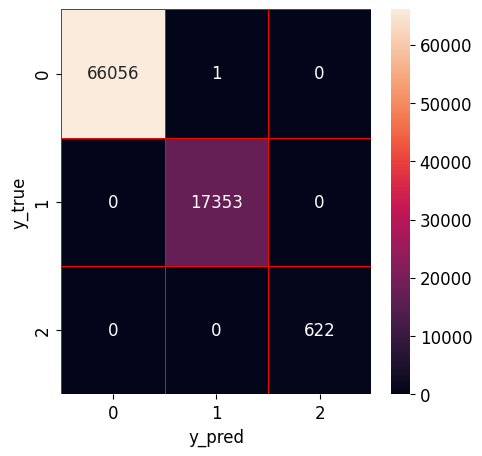

In [74]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time:  0.0008079650376277783 ms
Accuracy of RF: 0.9971802618328298
Precision of RF: 0.9971902569642598
Recall of RF: 0.9971802618328298
F1-score of RF: 0.9969576513359734
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120990
           1       1.00      1.00      1.00     31786
           2       1.00      0.68      0.81      1139

    accuracy                           1.00    153915
   macro avg       1.00      0.89      0.94    153915
weighted avg       1.00      1.00      1.00    153915



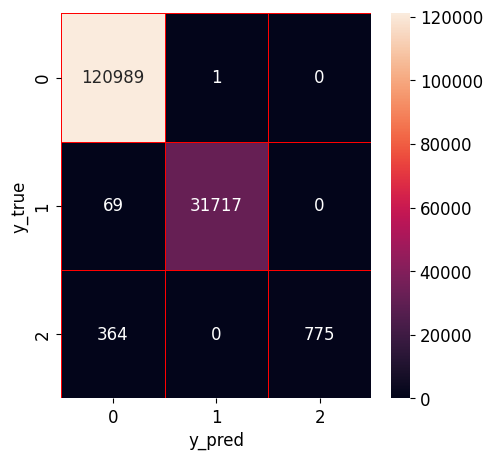

In [75]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [91]:
joblib.dump(rf, "fixed_friday_training_models/post_fs/rf_untuned.pkl")

['fixed_friday_training_models/post_fs/rf_untuned.pkl']

100%|██████████| 20/20 [14:02<00:00, 42.12s/trial, best loss: -0.9999687172074422]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 7, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 68}
Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



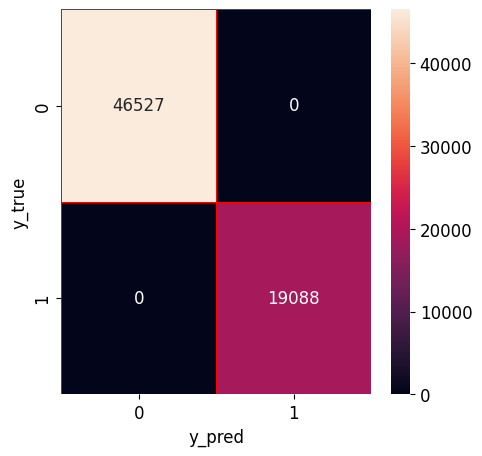

In [92]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3), n_jobs=8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [93]:
joblib.dump(rf, "fixed_friday_training_models/post_fs/rf.pkl")

['fixed_friday_training_models/post_fs/rf.pkl']

In [94]:
import gc
gc.collect()

29241

### ET

Training time:  5.624616622924805
Prediction time:  0.0005559224340416605 ms
Cross-Validation scores:  [0.9999639  0.99997112 0.99998556]
Mean of Cross-Validation scores:  0.9999735299728209
Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



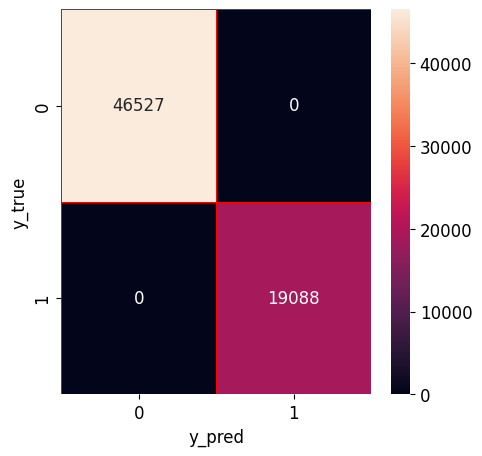

In [95]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [96]:
joblib.dump(et, "fixed_friday_training_models/post_fs/et_untuned.pkl")

['fixed_friday_training_models/post_fs/et_untuned.pkl']

100%|██████████| 20/20 [03:55<00:00, 11.78s/trial, best loss: -0.9999759362947089]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 13, 'max_features': 11, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 22}
Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



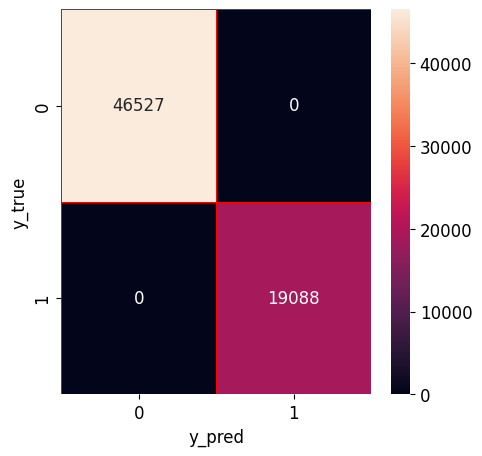

In [97]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_balanced, y_train_balanced, scoring='accuracy', n_jobs=8, cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [98]:
joblib.dump(et, "fixed_friday_training_models/post_fs/et.pkl")

['fixed_friday_training_models/post_fs/et.pkl']

In [99]:
import gc
gc.collect()

9747

### XGBoost

Training time:  2.7635576725006104
Prediction time per sample:  0.00036761777508104474
Cross-Validation scores:  [0.99784336 0.99998053 0.99996592]
Mean of Cross-Validation scores:  0.9992632691800688
Accuracy of XGBoost: 0.9999761995430312
Precision of XGBoost: 0.9999762193302556
Recall of XGBoost: 0.9999761995430312
F1-score of XGBoost: 0.9999762043135244
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66057
           1       1.00      1.00      1.00     17353
           2       1.00      1.00      1.00       622

    accuracy                           1.00     84032
   macro avg       1.00      1.00      1.00     84032
weighted avg       1.00      1.00      1.00     84032



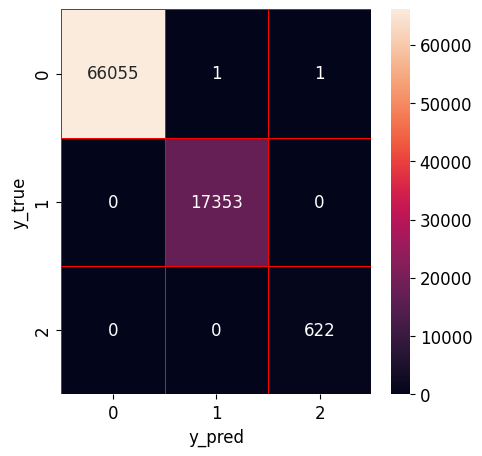

In [70]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Prediction time per sample:  0.0004350273549446364
Accuracy of XGBoost: 0.9976220641263035
Precision of XGBoost: 0.9976266528341365
Recall of XGBoost: 0.9976220641263035
F1-score of XGBoost: 0.9974831514888736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120990
           1       1.00      1.00      1.00     31786
           2       1.00      0.74      0.85      1139

    accuracy                           1.00    153915
   macro avg       1.00      0.91      0.95    153915
weighted avg       1.00      1.00      1.00    153915



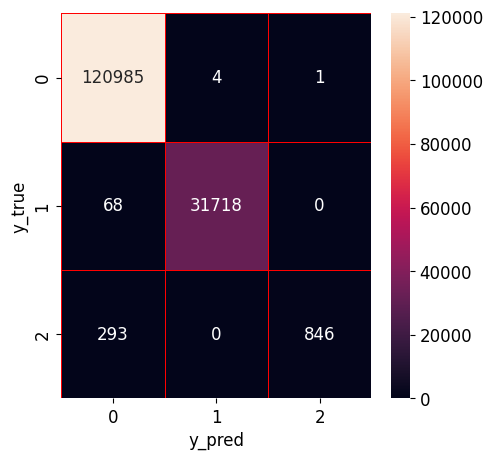

In [72]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test) * 1000)


y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [101]:
joblib.dump(xg, "fixed_friday_training_models/post_fs/xg_untuned.pkl")

['fixed_friday_training_models/post_fs/xg_untuned.pkl']

100%|██████████| 20/20 [00:07<00:00,  2.82trial/s, best loss: -1.0]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.3032994182755351, 'max_depth': 30, 'n_estimators': 100}
Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



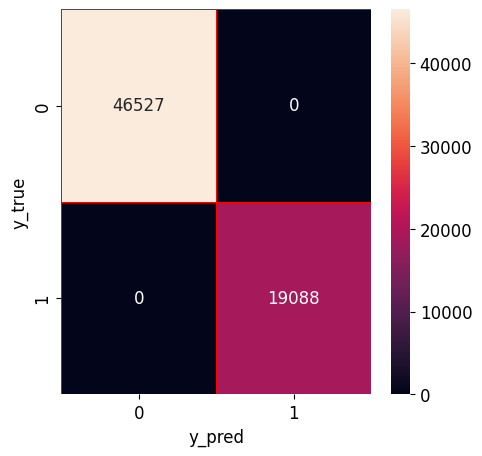

In [102]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [103]:
joblib.dump(xg, "fixed_friday_training_models/post_fs/xg.pkl")

['fixed_friday_training_models/post_fs/xg.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 80594, number of negative: 196449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4687
[LightGBM] [Info] Number of data points in the train set: 277043, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290908 -> initscore=-0.890979
[LightGBM] [Info] Start training from score -0.890979
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines

[LightGBM] [Info] Number of positive: 80594, number of negative: 196448
[LightGBM] [Info] Number of positive: 80594, number of negative: 196449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030343 seconds.
You can set `for

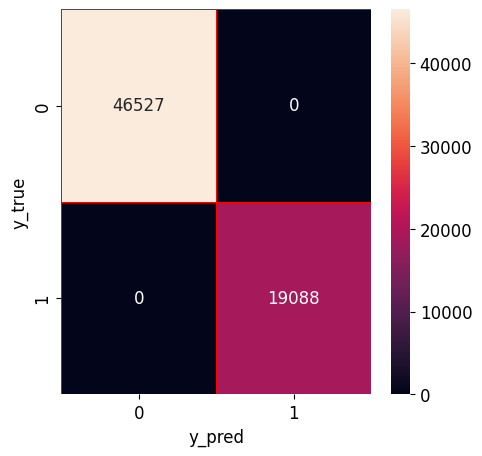

In [104]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [105]:
joblib.dump(lgbm, "fixed_friday_training_models/post_fs/lgbm_untuned.pkl")

['fixed_friday_training_models/post_fs/lgbm_untuned.pkl']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 120891, number of negative: 294673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4686                     
[LightGBM] [Info] Number of data points in the train set: 415564, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290908 -> initscore=-0.890977
[LightGBM] [Info] Start training from score -0.890977 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

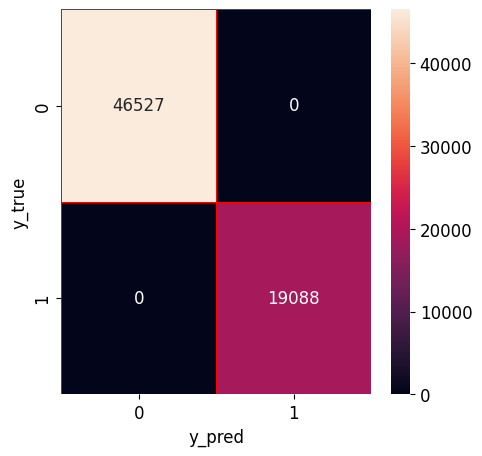

In [106]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [107]:
joblib.dump(lgbm, "fixed_friday_training_models/post_fs/lgbm.pkl")

['fixed_friday_training_models/post_fs/lgbm.pkl']

### CatBoost

Training time:  16.165517568588257
Prediction time per sample:  0.0001794743408910078
Cross-Validation scores:  [0.99998556 0.99997112 0.99997834]
Mean of Cross-Validation scores:  0.9999783426687124
Accuracy of CatBoost: 1.0
Precision of CatBoost: 1.0
Recall of CatBoost: 1.0
F1-score of CatBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



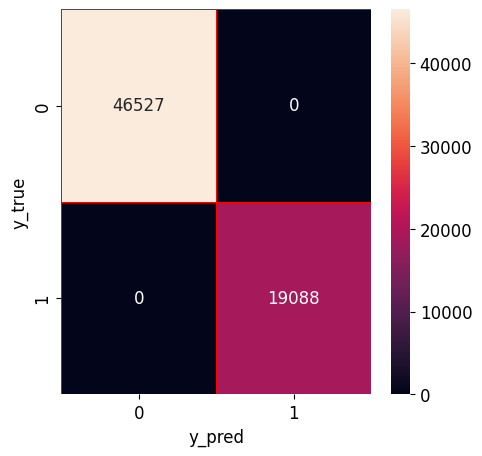

In [108]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [109]:
joblib.dump(cat, "fixed_friday_training_models/post_fs/cat_untuned.pkl")

['fixed_friday_training_models/post_fs/cat_untuned.pkl']

100%|██████████| 20/20 [05:56<00:00, 17.81s/trial, best loss: -1.0]
CatBoost: Hyperopt estimated optimum {'depth': 10, 'iterations': 500, 'learning_rate': 0.09498342564043545}
Accuracy of CatBoost: 1.0
Precision of CatBoost: 1.0
Recall of CatBoost: 1.0
F1-score of CatBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46527
           1       1.00      1.00      1.00     19088

    accuracy                           1.00     65615
   macro avg       1.00      1.00      1.00     65615
weighted avg       1.00      1.00      1.00     65615



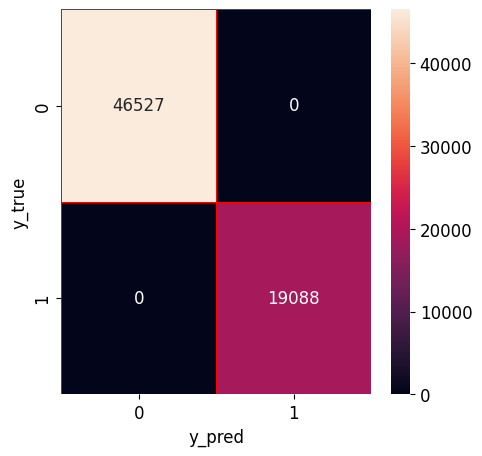

In [110]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_val)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [111]:
joblib.dump(cat, "fixed_friday_training_models/post_fs/cat.pkl")

['fixed_friday_training_models/post_fs/cat.pkl']

In [112]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_test=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_test=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_test=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_test=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_test=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_test=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_test=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_test=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_test=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_test=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_test=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_test=cat.predict_proba(X_val)


# Model Export

In [59]:
import joblib

joblib.dump(dt, "Models/dt.pkl")
joblib.dump(rf, "Models/rf.pkl")
joblib.dump(et, "Models/et.pkl")
joblib.dump(xg, "Models/xg.pkl")
joblib.dump(lgbm, "Models/lgbm.pkl")
joblib.dump(cat, "Models/cat.pkl")

['Models/cat.pkl']

In [60]:
lgbm_imported = joblib.load("Models/lgbm.pkl")

In [ ]:
import_test = lgbm_imported.predict(X_val).reshape(-1,1)
import_test

array([[0],
       [1],
       [3],
       ...,
       [0],
       [3],
       [3]])

In [122]:
top_3_models

['rf', 'et', 'lgbm']

In [71]:
fs

['Bwd Packet Length Min',
 'Bwd Packet Length Std',
 'Init_Win_bytes_forward',
 'Average Packet Size',
 'Init_Win_bytes_backward',
 'PSH Flag Count',
 'Bwd Packets/s',
 'Fwd PSH Flags',
 'Avg Bwd Segment Size',
 'Bwd Header Length',
 'Fwd Header Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'min_seg_size_forward',
 'Bwd Packet Length Mean',
 'Fwd Header Length.1',
 'Flow Bytes/s',
 'Bwd Packet Length Max',
 'Max Packet Length',
 'Flow IAT Min',
 'Total Length of Fwd Packets',
 'Fwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd IAT Min',
 'Avg Fwd Segment Size',
 'Total Fwd Packets',
 'Subflow Bwd Bytes',
 'Subflow Fwd Bytes',
 'Flow IAT Max',
 'Total Backward Packets',
 'Fwd IAT Mean',
 'Bwd IAT Min',
 'act_data_pkt_fwd',
 'Fwd Packets/s',
 'URG Flag Count',
 'Flow IAT Std',
 'Min Packet Length']

## Model selection

In [113]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [114]:
top_3_models

['xg', 'rf', 'lgbm']

In [115]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)
lgbm_test=lgbm_test.reshape(-1, 1)
cat_test=cat_test.reshape(-1, 1)

[LightGBM] [Info] Number of positive: 120891, number of negative: 294673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 415564, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290908 -> initscore=-0.890977
[LightGBM] [Info] Start training from score -0.890977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

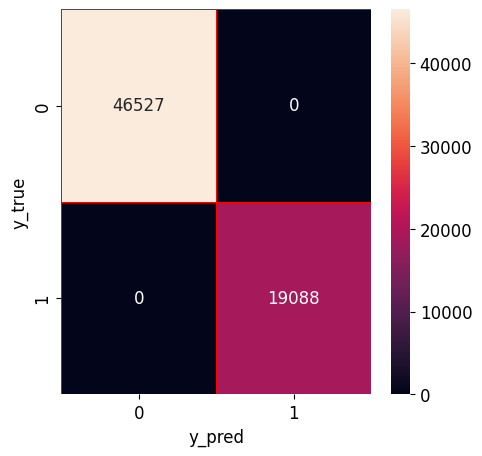

In [116]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_test_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [117]:
joblib.dump(stk, "fixed_friday_training_models/post_fs/stk1.pkl")

['fixed_friday_training_models/post_fs/stk1.pkl']

[LightGBM] [Info] Number of positive: 120891, number of negative: 294673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 415564, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290908 -> initscore=-0.890977
[LightGBM] [Info] Start training from score -0.890977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

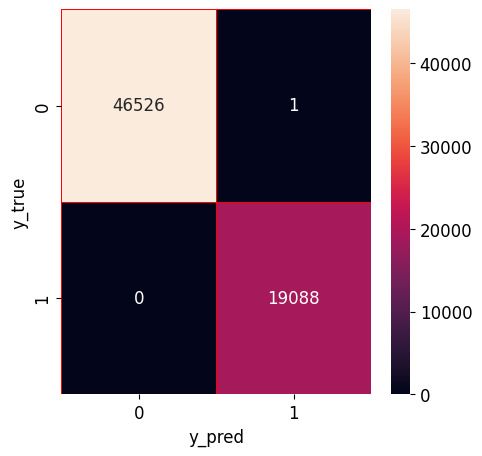

In [118]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [119]:
joblib.dump(stk, "fixed_friday_training_models/post_fs/stk2.pkl")

['fixed_friday_training_models/post_fs/stk2.pkl']

In [120]:
top_3_models

['xg', 'rf', 'lgbm']

[LightGBM] [Info] Number of positive: 120891, number of negative: 294673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1119
[LightGBM] [Info] Number of data points in the train set: 415564, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.290908 -> initscore=-0.890977
[LightGBM] [Info] Start training from score -0.890977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

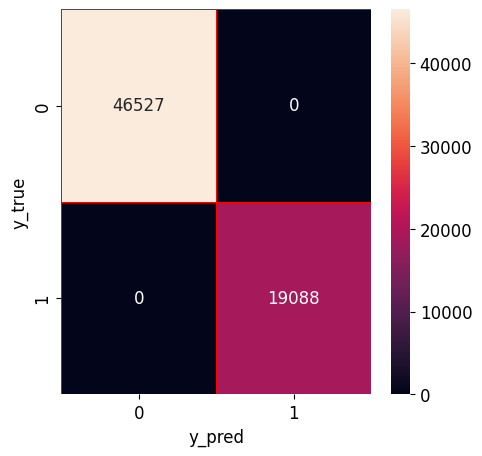

In [121]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_test_predictions = [globals()[model.lower() + '_test'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_test_proba = [globals()[model.lower() + '_prob_test'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_test_predictions + top_3_test_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps

In [122]:
joblib.dump(stk, "fixed_friday_training_models/post_fs/stk3.pkl")

['fixed_friday_training_models/post_fs/stk3.pkl']

# Final Test

In [123]:
df_test = pd.read_csv('/mnt/extra/datasets/processed/friday_annotated_test_rerun.csv')
df_test

,index,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,...,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label
0,0,192.168.10.9-205.174.165.73-7917-8080-6,192.168.10.9,7917,205.174.165.73,8080,6,2017-07-07 17:15:21.183058,561,1,...,0.0,0.0,0.0,-1,-1,0,0,0,561,Not Portscan
1,1,192.168.10.15-205.174.165.73-55703-8080-6,192.168.10.15,55703,205.174.165.73,8080,6,2017-07-07 17:15:36.401022,845,1,...,0.0,0.0,0.0,-1,-1,0,0,0,845,Not Portscan
2,2,192.168.10.15-205.174.165.73-55703-8080-6,192.168.10.15,55703,205.174.165.73,8080,6,2017-07-07 17:15:36.914385,777,1,...,0.0,0.0,0.0,-1,-1,0,0,0,777,Not Portscan
3,3,192.168.10.8-205.174.165.73-6257-8080-6,192.168.10.8,6257,205.174.165.73,8080,6,2017-07-07 17:15:37.780193,750,1,...,0.0,0.0,0.0,-1,-1,0,0,0,750,Not Portscan
4,4,192.168.10.8-205.174.165.73-6257-8080-6,192.168.10.8,6257,205.174.165.73,8080,6,2017-07-07 17:15:38.272414,478,1,...,0.0,0.0,0.0,-1,-1,0,0,0,478,Not Portscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65551,65594,172.16.0.1-192.168.10.50-64318-2222-6,172.16.0.1,64318,192.168.10.50,2222,6,2017-07-07 18:09:11.499555,64,1,...,0.0,0.0,0.0,-1,-1,0,0,0,64,Portscan
65552,65595,192.168.10.17-192.168.10.3-8398-53-17,192.168.10.17,8398,192.168.10.3,53,17,2017-07-07 18:12:10.812610,61049,2,...,0.0,0.0,0.0,-1,-1,0,0,0,61049,Not Portscan
65553,65596,172.16.0.1-192.168.10.50-41249-58080-6,172.16.0.1,41249,192.168.10.50,58080,6,2017-07-07 18:08:57.752078,49,1,...,0.0,0.0,0.0,-1,-1,0,0,0,49,Portscan
65554,65597,192.168.10.17-172.217.12.163-51051-443-6,192.168.10.17,51051,172.217.12.163,443,6,2017-07-07 19:56:02.486461,5836914,8,...,0.0,5649155.0,5649155.0,-1,-1,0,0,0,5836914,Not Portscan


In [124]:
X_test = df_test[fs]
X_test

,Total Connection Flow Time,Fwd Seg Size Min,Bwd RST Flags,Fwd Packet Length Max,Flow Duration,Packet Length Mean,Flow IAT Max,Fwd Packet Length Mean,Average Packet Size,Bwd IAT Total,...,Bwd Packets/s,Total Length of Fwd Packet,Fwd Packets/s,Fwd Act Data Pkts,Flow Bytes/s,Bwd Packet Length Max,Bwd Segment Size Avg,Flow IAT Min,Packet Length Max,Fwd Segment Size Avg
0,561,32,1,0.0,561,0.000000,561.0,0.000,0.000000,0.0,...,1782.531194,0.0,1782.531194,0,0.000000,0.0,0.0,561.0,0.0,0.000
1,845,32,1,0.0,845,0.000000,845.0,0.000,0.000000,0.0,...,1183.431953,0.0,1183.431953,0,0.000000,0.0,0.0,845.0,0.0,0.000
2,777,32,1,0.0,777,0.000000,777.0,0.000,0.000000,0.0,...,1287.001287,0.0,1287.001287,0,0.000000,0.0,0.0,777.0,0.0,0.000
3,750,32,1,0.0,750,0.000000,750.0,0.000,0.000000,0.0,...,1333.333333,0.0,1333.333333,0,0.000000,0.0,0.0,750.0,0.0,0.000
4,478,32,1,0.0,478,0.000000,478.0,0.000,0.000000,0.0,...,2092.050209,0.0,2092.050209,0,0.000000,0.0,0.0,478.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65551,64,24,1,0.0,64,0.000000,64.0,0.000,0.000000,0.0,...,15625.000000,0.0,15625.000000,0,0.000000,0.0,0.0,64.0,0.0,0.000
65552,61049,8,0,31.0,61049,58.000000,61044.0,31.000,58.000000,1.0,...,32.760569,62.0,32.760569,2,3800.226048,85.0,85.0,1.0,85.0,31.000
65553,49,24,1,0.0,49,0.000000,49.0,0.000,0.000000,0.0,...,20408.163265,0.0,20408.163265,0,0.000000,0.0,0.0,49.0,0.0,0.000
65554,5836914,32,0,517.0,5836914,57.357143,5649155.0,79.375,57.357143,5800428.0,...,1.027940,635.0,1.370587,3,137.572697,168.0,28.0,3.0,517.0,79.375


In [125]:
y_test = df_test['Label']
y_test

0        Not Portscan
1        Not Portscan
2        Not Portscan
3        Not Portscan
4        Not Portscan
             ...     
65551        Portscan
65552    Not Portscan
65553        Portscan
65554    Not Portscan
65555    Not Portscan
Name: Label, Length: 65556, dtype: object

In [126]:
y_test = labelencoder.transform(y_test)

In [127]:
# record the results
dt_test_real=dt.predict(X_test)
dt_prob_test_real=dt.predict_proba(X_test)

rf_test_real=rf.predict(X_test)
rf_prob_test_real=rf.predict_proba(X_test)

et_test_real=et.predict(X_test)
et_prob_test_real=et.predict_proba(X_test)

xg_test_real=xg.predict(X_test)
xg_prob_test_real=xg.predict_proba(X_test)

lgbm_test_real=lgbm.predict(X_test)
lgbm_prob_test_real=lgbm.predict_proba(X_test)

cat_test_real=cat.predict(X_test)
cat_prob_test_real=cat.predict_proba(X_test)

In [128]:
dt_test_real=dt_test_real.reshape(-1, 1)
rf_test_real=rf_test_real.reshape(-1, 1)
et_test_real=et_test_real.reshape(-1, 1)
xg_test_real=xg_test_real.reshape(-1, 1)
lgbm_test_real=lgbm_test_real.reshape(-1, 1)
cat_test_real=cat_test_real.reshape(-1, 1)

Accuracy of Stacking: 0.9997101714564647
Precision of Stacking: 0.9997102310995905
Recall of Stacking: 0.9997101714564647
F1-score of Stacking: 0.9997101378280308
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46483
           1       1.00      1.00      1.00     19073

    accuracy                           1.00     65556
   macro avg       1.00      1.00      1.00     65556
weighted avg       1.00      1.00      1.00     65556



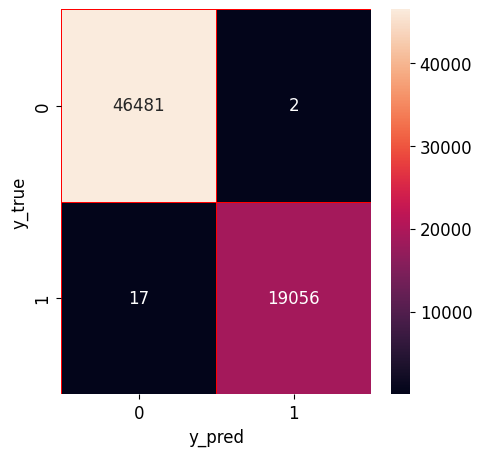

In [129]:
y_predict=lgbm.predict(X_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [130]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]

top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions + top_3_test_real_proba, axis=1)

Accuracy of Stacking: 0.9997101714564647
Precision of Stacking: 0.9997102310995905
Recall of Stacking: 0.9997101714564647
F1-score of Stacking: 0.9997101378280308
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46483
           1       1.00      1.00      1.00     19073

    accuracy                           1.00     65556
   macro avg       1.00      1.00      1.00     65556
weighted avg       1.00      1.00      1.00     65556



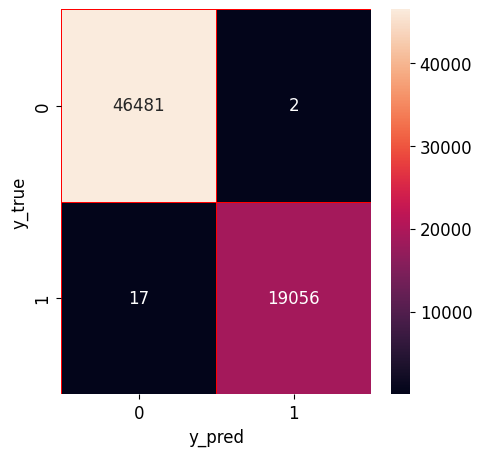

In [131]:
y_predict=stk.predict(x_test_real)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()